# 量化策略回测框架 (修改版 2)

## 修改核心:
1.  **交易逻辑**:
    - 每个非零信号在 `T-1` 时刻产生，会触发两个事件：一个在 `T` 时刻的 **开仓** 事件，以及一个在 `T+10` 时刻的 **平仓** 事件。
    - 所有的开仓和平仓事件被放置在同一个时间轴上。
2.  **头寸净额结算 (Netting)**:
    - 在每个时间点，系统会加总所有到期的事件，计算出该时间点的 **净头寸变化量 (Net Trades)**。
3.  **手续费计算**:
    - 手续费仅在 **净头寸发生变化** 的时刻计算，费用正比于净头寸变化的绝对值。这完美解决了因操作重叠导致手续费被重复计算的问题。
4.  **收益计算**:
    - 策略的收益基于每日的 **持有头寸 (Position)** 和市场的 **价格变动 (Market Return)** 进行计算。
    - 最终收益以 **单利 (Simple Interest)** 模式进行累加。
5.  **新增**: 在评估模块加入了策略收益与 `signal * return` 基准的相关性分析，用于逻辑健全性检查。

In [6]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from tabulate import tabulate
from colorama import Fore, Style
import pickle
from pathlib import Path

---
## 1. 日志和绘图设置

In [7]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数 (源于旧代码)

In [ ]:
def run_netted_backtest(prices, signals, commission_rate=0.0001, holding_period=10):
    """
    执行基于“头寸净额结算”和“单利”的向量化回测。

    参数:
    - prices (pd.Series): 'close'价格序列。
    - signals (pd.Series): 交易信号序列 (1 for long, -1 for short, 0 for neutral)。
    - commission_rate (float): 单边交易手续费率。
    - holding_period (int): 每笔交易的固定持有周期。

    返回:
    - pd.DataFrame: 包含回测详细过程的DataFrame。
    """
    logging.info(f"🤔 开始执行头寸净额结算回测 (单利, {holding_period}-period持有期)...")

    # --- 1. 生成所有独立的交易事件 ---
    # 每个信号会产生一个开仓事件和一个方向相反的平仓事件
    all_events = []
    # 动态获取数据的时间间隔，处理可能的缺失索引
    if isinstance(prices.index, pd.DatetimeIndex):
        time_interval = prices.index.to_series().diff().median()
    else:
        # Fallback for non-datetime indexes
        time_interval = 1 

    for timestamp, signal_value in signals.items():
        if signal_value != 0:
            # 开仓事件发生在信号出现的下一个bar
            open_time = timestamp + time_interval
            # 平仓事件发生在开仓后的第 holding_period 个bar
            close_time = open_time + holding_period * time_interval
            
            all_events.append({'timestamp': open_time, 'change': signal_value})
            all_events.append({'timestamp': close_time, 'change': -signal_value})

    if not all_events:
        logging.warning("未发现任何交易信号，返回空结果。")
        return pd.DataFrame()

    # --- 2. 聚合事件，计算每个时间点的净头寸变化 ---
    events_df = pd.DataFrame(all_events)
    net_trades = events_df.groupby('timestamp')['change'].sum()

    # --- 3. 构建包含所有时间点的完整回测DataFrame ---
    backtest_df = pd.DataFrame(index=prices.index)
    backtest_df['close'] = prices
    backtest_df['signal'] = signals # 将原始信号加入结果中，便于后续分析

    backtest_df['net_trades'] = net_trades
    backtest_df['net_trades'] = backtest_df['net_trades'].fillna(0)

    # --- 4. 计算随时间变化的头寸 ---
    backtest_df['position'] = backtest_df['net_trades'].cumsum()

    # --- 5. 计算策略收益与成本 ---
    backtest_df['market_returns'] = backtest_df['close'].pct_change()
    backtest_df['strategy_gross_returns'] = backtest_df['position'].shift(1) * backtest_df['market_returns']
    backtest_df['transaction_costs'] = abs(backtest_df['net_trades']) * commission_rate
    backtest_df['strategy_net_returns'] = backtest_df['strategy_gross_returns'] - backtest_df['transaction_costs']

    # --- 6. 计算累计收益曲线 (单利模式) ---
    backtest_df['equity_curve_simple_return'] = backtest_df['strategy_net_returns'].cumsum()
    
    backtest_df = backtest_df.fillna(0)

    logging.info("🎉 头寸净额结算回测完成。")
    return backtest_df

In [9]:
def evaluate_performance(backtest_results, initial_capital=100000):
    """
    评估策略表现 (适配于头寸净额结算和单利模式)。
    """
    logging.info("🤔🤔🤔 开始评估策略表现 (净额结算版)...")

    if backtest_results.empty:
        logging.error("回测结果为空，无法进行评估。")
        return

    # --- 数据提取 ---
    net_returns = backtest_results['strategy_net_returns']
    equity_curve_rate = backtest_results['equity_curve_simple_return']
    equity_curve_value = initial_capital * (1 + equity_curve_rate)
    
    market_returns = backtest_results['market_returns']
    benchmark_equity = initial_capital * (1 + market_returns).cumprod()

    # --- 交易统计 ---
    trades = backtest_results['net_trades'][backtest_results['net_trades'] != 0]
    total_trades = len(trades)

    # --- 核心指标计算 ---
    total_days = (equity_curve_rate.index[-1] - equity_curve_rate.index[0]).days
    duration_years = total_days / 365.25 if total_days > 0 else 1
    total_return = equity_curve_rate.iloc[-1]
    annualized_return = total_return / duration_years if duration_years > 0 else 0
    monthly_net_returns = net_returns.resample('M').sum()
    annualization_factor = 12
    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        annualized_volatility = monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        annualized_volatility = 0
        
    running_max = equity_curve_value.cummax()
    drawdown = running_max - equity_curve_value
    max_drawdown_value = drawdown.max()
    peak_at_mdd_start = running_max.loc[drawdown.idxmax()] if not drawdown.empty else initial_capital
    max_drawdown_pct = max_drawdown_value / peak_at_mdd_start if peak_at_mdd_start > 0 else 0
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0
    calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct != 0 else 0

    # --- (新增) Sanity Check: Correlation with simple signal*return ---
    simple_benchmark_returns = backtest_results['signal'] * backtest_results['market_returns']
    simple_benchmark_cumsum = simple_benchmark_returns.cumsum()
    correlation = equity_curve_rate.corr(simple_benchmark_cumsum) if not equity_curve_rate.empty and not simple_benchmark_cumsum.empty else 0
    
    # --- 打印报告 ---
    print("\n" + "="*80)
    print(Fore.CYAN + Style.BRIGHT + " " * 20 + "策略性能评估报告 (头寸净额结算版)" + " " * 20 + Style.RESET_ALL)
    print("="*80)

    # (新增) 打印相关性分析表格
    print("\n" + Fore.YELLOW + Style.BRIGHT + "="*30 + " 与基准的相关性分析 " + "="*30 + Style.RESET_ALL)
    corr_table = [
        ["策略累计收益 vs. (signal * return)累计收益", f"{correlation:.4f}"]
    ]
    print(tabulate(corr_table, headers=["指标 (Sanity Check)", "相关系数"], tablefmt="grid", stralign="center"))

    print("\n" + Fore.BLUE + Style.BRIGHT + "="*30 + " 核心性能指标 " + "="*30 + Style.RESET_ALL)
    detail_headers = ["指标名称", "值"]
    detail_table = [
        ["模式", "头寸净额结算 / 单利"],
        ["总收益率 (Total Return)", f"{total_return:.2%}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.2%}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.2%}"],
        ["夏普比率 (Sharpe Ratio)", f"{sharpe_ratio:.4f}"],
        ["最大回撤 (Max Drawdown)", f"{max_drawdown_pct:.2%}"],
        ["卡玛比率 (Calmar Ratio)", f"{calmar_ratio:.4f}"],
        ["净头寸变化次数 (Total Trades)", f"{total_trades}"],
        ["最终资金 (Final Capital)", f"${equity_curve_value.iloc[-1]:,.2f}"]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    # --- 绘制权益曲线图 ---
    fig, ax1 = plt.subplots(figsize=(20, 10))
    
    equity_curve_value.plot(label='Strategy Equity (Netting & Simple Interest)', lw=2, color='royalblue', ax=ax1)
    benchmark_equity.plot(label='Buy & Hold Benchmark', lw=2, linestyle='--', color='darkorange', ax=ax1)
    
    ax1.set_title('Strategy Equity Curve vs. Benchmark', fontsize=16)
    ax1.set_ylabel('Equity Value ($)', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

    logging.info("🎊🎊🎊 策略评估完成 🎊🎊🎊")

---
## 3. 主程序执行

2025-07-24 15:03:46,264 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-24 15:03:46,273 - INFO - 数据加载成功。
2025-07-24 15:03:46,275 - INFO - 🤔 开始执行头寸净额结算回测 (单利, 10-period持有期)...


数据预览:
                     signal     close
open_time                            
2021-09-27 00:00:00       0  43050.80
2021-09-27 00:15:00       0  43048.11
2021-09-27 00:30:00       0  43431.49
2021-09-27 00:45:00       0  43851.20
2021-09-27 01:00:00       0  43912.15

数据时间范围: 2021-09-27 00:00:00 -> 2025-06-30 23:45:00
数据形状: (131808, 2)


2025-07-24 15:03:46,662 - INFO - 🎉 头寸净额结算回测完成。
2025-07-24 15:03:46,666 - INFO - 回测结果 DataFrame (展示非零头寸变化的前5行):
2025-07-24 15:03:46,671 - INFO - 🤔🤔🤔 开始评估策略表现 (净额结算版)...


                        close  signal  net_trades  position  market_returns  \
open_time                                                                     
2021-09-27 06:30:00  44037.70       1         1.0       1.0        0.000608   
2021-09-27 06:45:00  43722.06       1         1.0       2.0       -0.007167   
2021-09-27 07:00:00  43790.32       1         1.0       3.0        0.001561   
2021-09-27 07:15:00  43759.99       0         1.0       4.0       -0.000693   
2021-09-27 07:45:00  43665.96       1         1.0       5.0       -0.002619   

                     strategy_gross_returns  transaction_costs  \
open_time                                                        
2021-09-27 06:30:00                0.000000             0.0002   
2021-09-27 06:45:00               -0.007167             0.0002   
2021-09-27 07:00:00                0.003122             0.0002   
2021-09-27 07:15:00               -0.002078             0.0002   
2021-09-27 07:45:00               -0.010474       

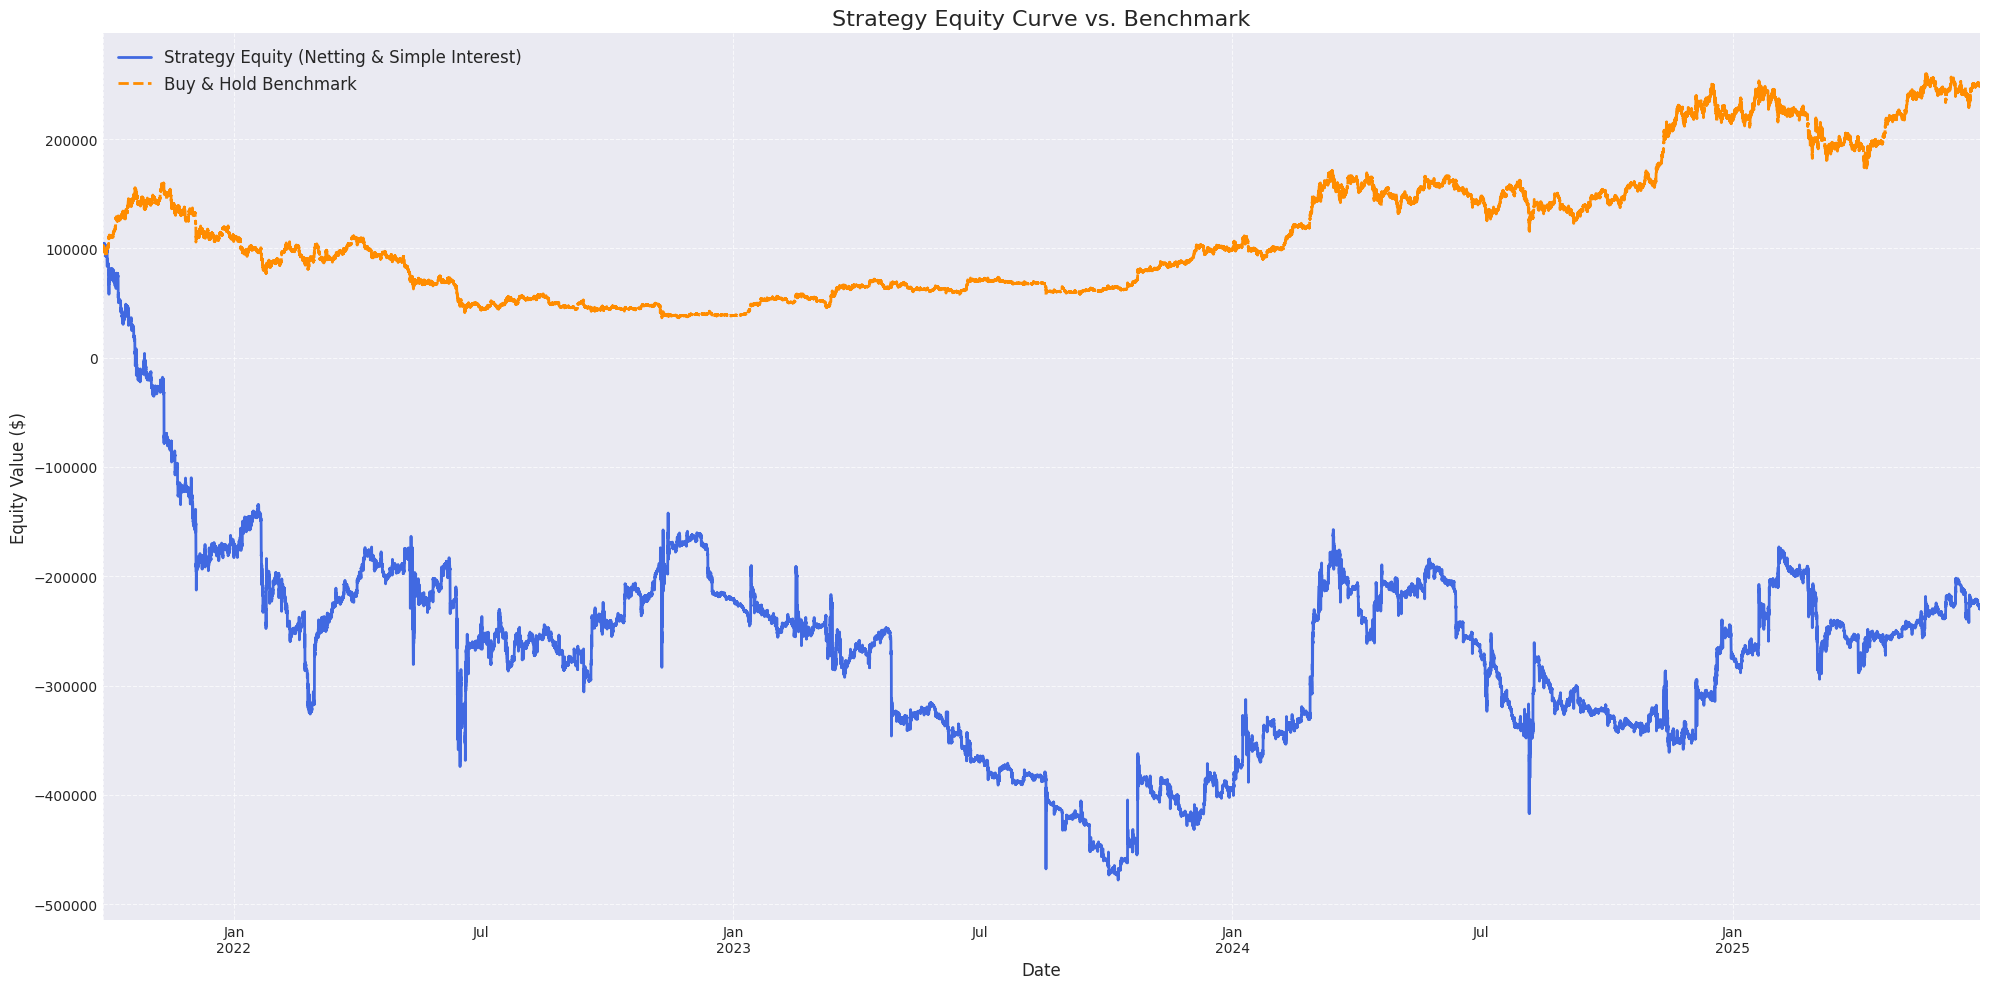

2025-07-24 15:03:49,550 - INFO - 🎊🎊🎊 策略评估完成 🎊🎊🎊


In [10]:
if __name__ == '__main__':
    # --- 1. 参数配置 ---
    # 文件路径
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    
    # 回测参数
    COMMISSION_RATE = 0.0002     # 单边手续费 (作用于净头寸变化)
    INITIAL_CAPITAL = 100000     # 初始资金
    HOLDING_PERIOD = 10          # 固定持有10个15分钟bar
    
    # --- 2. 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    
    file_path = Path(FILE_PATH)
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # 确保索引是datetime类型并设置名称
        data.index = pd.to_datetime(data.index)
        data = data.rename_axis('open_time')

        logging.info("数据加载成功。")
        print("数据预览:")
        print(data.head())
        print(f"\n数据时间范围: {data.index.min()} -> {data.index.max()}")
        print(f"数据形状: {data.shape}")

    except FileNotFoundError:
        logging.error(f"错误: 无法找到数据文件于 {FILE_PATH}")
        data = None
    except Exception as e:
        logging.error(f"加载数据时发生错误: {e}")
        data = None

    # --- 3. 执行回测 (使用新版函数) ---
    if data is not None and not data.empty:
        backtest_results = run_netted_backtest(
            prices=data['close'],
            signals=data['signal'],
            commission_rate=COMMISSION_RATE,
            holding_period=HOLDING_PERIOD
        )
        
        logging.info("回测结果 DataFrame (展示非零头寸变化的前5行):")
        print(backtest_results[backtest_results['net_trades'] != 0].head())

        # --- 4. 性能评估 ---
        evaluate_performance(
            backtest_results, 
            INITIAL_CAPITAL
        )
    else:
        logging.warning("由于数据加载失败或数据为空，回测和评估步骤已跳过。")